In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm

from utility_py import *

class PINNs(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layer):
        super(PINNs, self).__init__()

        layers = []
        for i in range(num_layer-1):
            if i == 0:
                layers.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))
                layers.append(nn.Tanh())
            else:
                layers.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
                layers.append(nn.Tanh())

        layers.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))

        self.linear = nn.Sequential(*layers)

    def forward(self, x, t):
        src = torch.cat((x,t), dim=-1)
        return self.linear(src)



In [3]:
# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833
# @article{zhao2023pinnsformer,
#   title={PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks},
#   author={Zhao, Leo Zhiyuan and Ding, Xueying and Prakash, B Aditya},
#   journal={arXiv preprint arXiv:2307.11833},
#   year={2023}
# }

import pdb

#from utility_py import get_clones

class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()
        
    def forward(self, x):
        x2 = self.act1(x)
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs): 
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x):
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x)

class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()
        
    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)



class PINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        super(PINNsformer, self).__init__()

        self.linear_emb = nn.Linear(2, d_model)

        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        ])

    def forward(self, x, t):
        src = torch.cat((x,t), dim=-1)
        src = self.linear_emb(src)

        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        # pdb.set_trace()
        # raise Exception('stop')
        return output

In [4]:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)



In [5]:
seed = 1
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.is_available() 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
step_size = 1e-4

cuda:0


In [7]:

res, b_left, b_right, b_upper, b_lower = get_data([0, L], [0, 1], 51, 51)
res_test, _, _, _, _ = get_data([0, L], [0, 1], 101, 101)

# Define the initial condition for u(x, 0)
def u_init(x):
   
    return np.sin(n * np.pi * x / L)
print(res[:, 0])

# Apply the initial condition to the spatial points at t=0
init_cond = u_init(res[:, 0])  # Assuming t=0 corresponds to the first time point

# Extend time sequence
res = make_time_sequence(res, num_step=5, step=1e-4)
b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)

# Convert to PyTorch tensors
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

# Initial condition as tensor
init_cond = torch.tensor(init_cond, dtype=torch.float32).to(device)

# Separate spatial (x) and temporal (t) components
x_res, t_res = res[:, :, 0:1], res[:, :, 1:2]
x_left, t_left = b_left[:, :, 0:1], b_left[:, :, 1:2]
x_right, t_right = b_right[:, :, 0:1], b_right[:, :, 1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]


# Initialize model weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


[0.   0.02 0.04 ... 0.96 0.98 1.  ]


In [8]:
model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)
import torch.optim as optimer
model.apply(init_weights)
#optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
optim = optimer.Adam(model.parameters(), lr=1e-4)

print(model)
print(get_n_params(model))

PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequen

In [9]:
#print(x_res)
def check_nan(tensor, name):
    if torch.isnan(tensor).any():
        print(f"NaNs detected in {name}")
loss_track = []
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions
k= 0 
t_ic = torch.zeros_like(x_lower)
for i in tqdm(range(250)):
    k+=1
    if k == 100:
            print("progress")
            k=0
    def closure():
        
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left) #  Left boundary of the spatial domain (x=0) over all times.
        pred_right = model(x_right, t_right) # t_right is 1
        #print(pred_res)
        pred_ic = model(x_right,t_ic )
        pred_upper = model(x_upper, t_upper) #  All spatial points at the final time step (x=1).
        pred_lower = model(x_lower, t_lower) #  All spatial points at the initial time step (x=0).
        pred_res_t0 = pred_res[:, 0, :]


        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        
        check_nan(u_x, 'u_x')
        check_nan(u_xx, 'u_xx')
        check_nan(u_t, 'u_t')
       
        alpha =a   # thermal diffusivity (can be modified)
        #1. PDE LOSS eesidual
        loss_res =torch.mean((alpha * u_xx - u_t )**2 )


        #2. Loss for initial condition

        loss_ic = torch.mean((pred_ic- torch.sin(n * torch.pi * x_right / L))**2)
        
        
        # 3. Boundary conditions: enforce Dirichlet BCs (u(0,t) = u(L,t) = 0)
        loss_bc_1 =loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower) ** 2)
        #loss_bc_2 =  torch.mean((pred_left-pred_right) ** 2) 
        loss_bc = loss_bc_1
        
        loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])

        loss = 2*loss_res + loss_ic + loss_bc
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)


  0%|          | 0/250 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 40%|████      | 100/250 [00:16<00:24,  6.10it/s]

progress


 80%|████████  | 200/250 [00:33<00:08,  6.15it/s]

progress


100%|██████████| 250/250 [00:41<00:00,  6.03it/s]


In [160]:
print(f"Length of loss_track: {len(loss_track)}")

Length of loss_track: 1253


In [161]:
print('Loss Res: {:4f}, Loss_IC: {:4f}, loss_bc: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

torch.save(model.state_dict(), './1dreaction_pinnsformer.pt')

Loss Res: 0.000002, Loss_IC: 0.000000, loss_bc: 0.000000
Train Loss: 0.000002


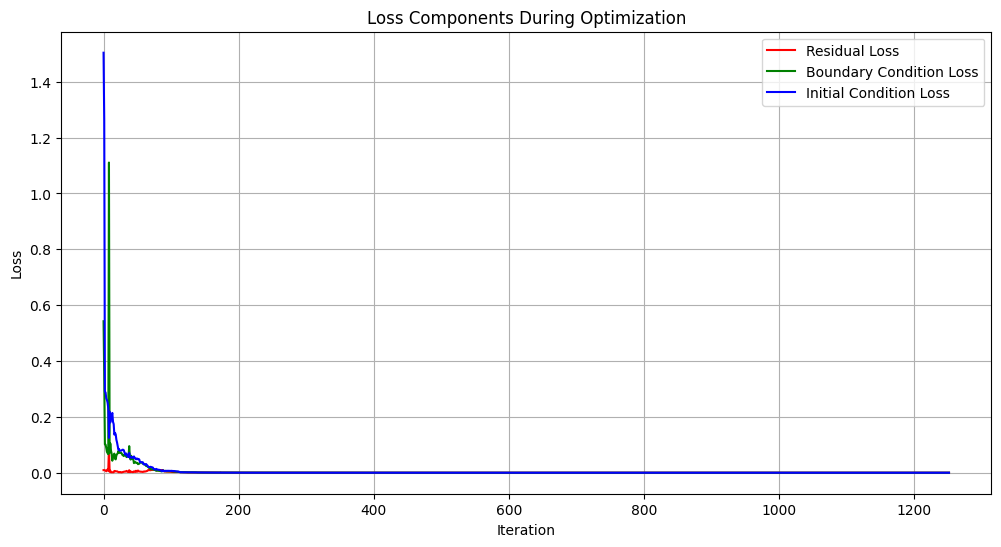

In [162]:


# Convert loss_track to a NumPy array for easier slicing
loss_track = np.array(loss_track)

# Extract each loss component
residual_loss = loss_track[:, 0]
boundary_condition_loss = loss_track[:, 2]
initial_condition_loss = loss_track[:, 1]

# Plot loss components
plt.figure(figsize=(12, 6))
plt.plot(residual_loss, label='Residual Loss', color='r')
plt.plot(boundary_condition_loss, label='Boundary Condition Loss', color='g')
plt.plot(initial_condition_loss, label='Initial Condition Loss', color='b')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Components During Optimization')
plt.legend()
plt.grid(True)
plt.show()

Relative L1 error: 0.001704
Relative L2 error: 0.001318


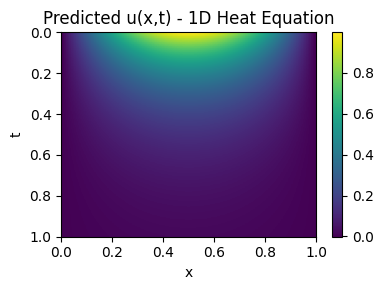

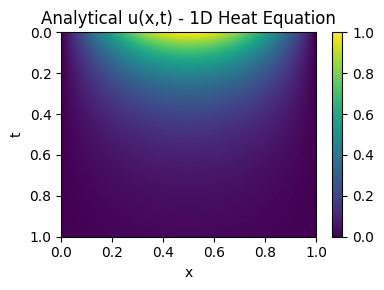

In [163]:

#Visualization for 1D heat equation
import numpy as np
import matplotlib.pyplot as plt

#Generate the test data with the correct dimensions for the heat equation
res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

# Predict using the model
with torch.no_grad():
    pred = model(x_test, t_test)[:, 0:1]
    pred = pred.cpu().detach().numpy()

# Reshape the prediction to fit 101x101 grid (space and time)
pred = pred.reshape(101, 101)

#Final Desired Equation
def u_ana(x, t, alpha=0.4, L=1, n=1):
    return np.exp(-(n**2 * np.pi**2 * alpha * t) / (L**2)) * np.sin(n * np.pi * x / L)
    #return np.exp(-n**2 * np.pi**2 * alpha * t) * np.sin(n * np.pi * x / L)

#Get the test data again for analytical solution comparison
res_test, _, _, _, _ = get_data([0, L], [0, 1], 101, 101)

# Compute the analytical solution for the heat equation
u = u_ana(res_test[:,0], res_test[:,1]).reshape(101, 101)

#Compute relative errors (L1 and L2)
rl1 = np.sum(np.abs(u - pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u - pred) ** 2) / np.sum(u ** 2))

print('Relative L1 error: {:4f}'.format(rl1))
print('Relative L2 error: {:4f}'.format(rl2))

#Visualization of predicted solution u(x,t)
plt.figure(figsize=(4, 3))
plt.imshow(pred, extent=[0, L, 1, 0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t) - 1D Heat Equation')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dheat_pinnsformer_pred.png')
plt.show()

#Visualization of analytical solution u_ana(x,t)
plt.figure(figsize=(4, 3))
plt.imshow(u, extent=[0, L, 1, 0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Analytical u(x,t) - 1D Heat Equation')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dheat_analytical.png')
plt.show()
